In [1]:
bplot=4

In [2]:
import numpy
import matplotlib.pyplot as plt
import scipy.fftpack as fftp

In [3]:
# Download the data file that we need to run these examples
import os
outputfilepath='./d0045400.dt3.h5'
if not os.path.exists(outputfilepath):
    import urllib.request
    url='https://data.amisr.com/database/tmp/isr_school_2020/d0045400.dt3.h5'

    print('Downloading data file...')
    urllib.request.urlretrieve(url,outputfilepath)

    print('...Done!')

In [4]:
print(os.path.exists(outputfilepath))

True


In [5]:
#Load an example file
import io_utils #wrapper for pytables routines

#This is one file from a WorldDay35 experiment
f=io_utils.read_whole_h5file(outputfilepath)

In [6]:
rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Total noise pulses in the whole file
pulsesIntegratedNoise=f['/S/Noise']['PulsesIntegrated'][0,:]

In [7]:
#handy utility for taking Fourier transforms of onesided ACFs
def onsideFT(data,rate=1.0):
    if data.ndim==1:
        flip=numpy.concatenate((numpy.conj(data[-1:0:-1]),data[:]))
        flip=numpy.concatenate((numpy.zeros((1)),flip))
        spec=(fftp.fftshift(fftp.fft(fftp.ifftshift(flip)))).real
    elif data.ndim==2:
        flip=numpy.concatenate((numpy.conj(data[:,-1:0:-1]),data[:,:]),axis=-1)
        flip=numpy.concatenate((numpy.zeros((flip.shape[0],1)),flip),axis=-1)
        spec=(fftp.fftshift(fftp.fft(fftp.ifftshift(flip,axes=-1),axis=-1),axes=-1)).real
        
    freq=fftp.fftshift(fftp.fftfreq(spec.shape[-1],d=rate))
    
    #padding trick to get pcolormesh to plot the whole thing
    freq=numpy.concatenate((freq,numpy.array([freq[-1]+freq[-1]-freq[-2]])))
    
    return spec,freq

Text(0.5, 1.0, 'Noise Spectrum')

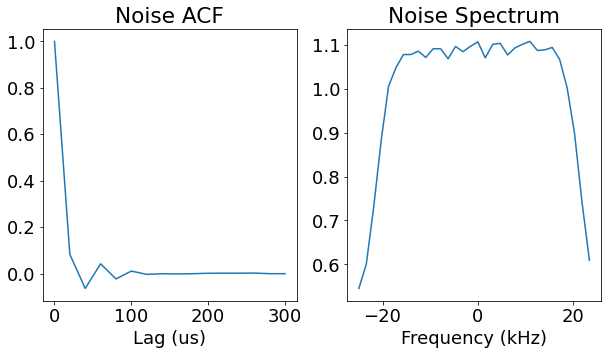

In [8]:
noiseacf=f['/S/Noise/Acf']['Data'][:,:,:,:,0]+1j*f['/S/Noise/Acf']['Data'][:,:,:,:,1]
#Take a mean over all noise ranges
noiseacfmr=numpy.mean(noiseacf,axis=-1)
#Take a mean over all records in the file
noiseacfm=numpy.mean(noiseacfmr,axis=0)

noisespecm,freq=onsideFT(noiseacfm,rate=1e-6*(lag[1]-lag[0]))

plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18

fig,axarr = plt.subplots(1,2)
axarr[0].plot(lag[:-1],noiseacfm[bplot,:].real/noiseacfm[bplot,0].real)
axarr[0].set_xlabel('Lag (us)')
axarr[0].set_title('Noise ACF')

axarr[1].plot(freq[:-1]*1e-3,noisespecm[bplot,:].real/noiseacfm[bplot,0].real)
axarr[1].set_xlabel('Frequency (kHz)')
axarr[1].set_title('Noise Spectrum')

In [9]:
#This example shows how to use a custom integration time rather than following the records in the file

K=4096 #user-specified number of pulses to integrate

#Sizes of arrays
nRecs,nPulses,nRawRanges,nIQs=f['/Raw11/Raw/Samples']['Data'].shape
nRecs,nBeams,nLags,nRanges,nIQs=f['/S/Data/Acf']['Data'].shape

#We need to be careful about off-the-end index issues
assert(nRanges==nRawRanges-nLags)
nLags2=nLags//2
r1=nLags2-1
r2=nRawRanges-nLags2-1
#reduced set of ranges for ACF
rangeAcf=f['/Raw11/Raw/Samples']['Range'][0,r1:r2]

#Allocate working arrays
acf0=1j*numpy.zeros((nPulses,nLags,nRanges))
acfCust=1j*numpy.zeros((1,nBeams,nLags,nRanges))
pulsesIntegratedCust=numpy.zeros((1,nBeams),dtype='int')

#Raw voltages
raw0=f['/Raw11/Raw/Samples']['Data'][:,:,:,0]+1j*f['/Raw11/Raw/Samples']['Data'][:,:,:,1]

#Do one record at a time to avoid excessive memory usage
rec=0
while(rec<nRecs and pulsesIntegratedCust[0,0]<K):   
    for ell in range(nLags):
        ell2m=ell//2 #note the use of integer division
        ell2p=ell//2+ell%2
        acf0[:,ell,:]=numpy.conj(raw0[rec,:,r1-ell2m:r2-ell2m])*raw0[rec,:,r1+ell2p:r2+ell2p]
        
    #Sort by beam and integrate
    #Using the RadacHeader Beamcodes guarantees that this will work, 
    #even for exotic experiments with irregular beam revisit patterns
    for b in range(nBeams):
        bcode=f['/S/Data']['Beamcodes'][0,b]
        ind=numpy.where(f['/Raw11/Raw/RadacHeader']['BeamCode'][rec,:]==bcode)[0]
        pulsesToDo=numpy.min((K-pulsesIntegratedCust[0,b],acf0[ind,:,:].shape[0]))
        acfCust[0,b,:,:]=acfCust[0,b,:,:]+numpy.sum(acf0[ind[:pulsesToDo],:,:],axis=0)
        pulsesIntegratedCust[0,b]=pulsesIntegratedCust[0,b]+pulsesToDo
        
    rec=rec+1
    
rng=f['/S/Data/Acf']['Range'][0,:]*1e-3 #km
lag=f['/S/Data/Acf']['Lags'][0,:]*1e6 #us

#padding tricks to get pcolormesh to actually plot the whole array
rng=numpy.concatenate((rng,numpy.array([rng[-1]+rng[-1]-rng[-2]])))
lag=numpy.concatenate((lag,numpy.array([lag[-1]+lag[-1]-lag[-2]])))

#Normalize the number of pulses Integrated for the purpose of plotting on one colorbar
facf=acfCust[0,bplot,:,:]/pulsesIntegratedCust[0,bplot]

#Noise subtraction with the pulsesIntegrated normalization done correctly
noiseacfnorm=numpy.expand_dims(noiseacfm[bplot,:],axis=-1)/pulsesIntegratedNoise[bplot]

acf=facf-noiseacfnorm

noisespecnorm,freq=onsideFT(noiseacfnorm[:,0],rate=1e-6*(lag[1]-lag[0]))
fspec,freq=onsideFT(facf.T,rate=1e-6*(lag[1]-lag[0]))
spec,freq=onsideFT(acf.T,rate=1e-6*(lag[1]-lag[0]))


/var/folders/68/8hb03y4d1hl_nnlyd709l75m0000gn/T/ipykernel_53176/583473815.py:15: RuntimeWarning: invalid value encountered in log10
  axarr[2].pcolormesh(freq,rng,numpy.log10(spec),vmin=numpy.log10(vmax*32/100.0),vmax=numpy.log10(vmax*32.0),cmap='viridis')


Text(0.5, 0, 'Frequency (kHz)')

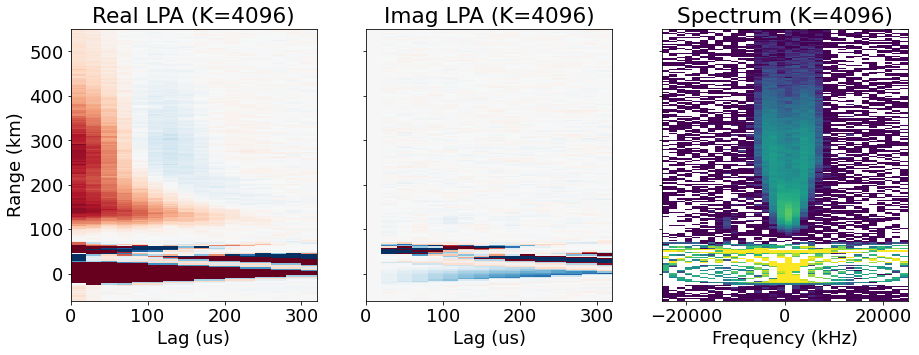

In [10]:
plt.rcParams['figure.figsize']=15,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,3,sharey=True)
#I strongly recommend setting symmetric color limits so you can clearly see the zero crossings
vmin=-3e3
vmax=3e3
axarr[0].pcolormesh(lag,rng,acf.real.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[0].set_title('Real LPA (K=%d)'%K)
axarr[0].set_xlabel('Lag (us)')
axarr[0].set_ylabel('Range (km)')
axarr[1].pcolormesh(lag,rng,acf.imag.T,vmin=vmin,vmax=vmax,cmap='RdBu_r')
axarr[1].set_title('Imag LPA (K=%d)'%K)
axarr[1].set_xlabel('Lag (us)')

axarr[2].pcolormesh(freq,rng,numpy.log10(spec),vmin=numpy.log10(vmax*32/100.0),vmax=numpy.log10(vmax*32.0),cmap='viridis')
axarr[2].set_title('Spectrum (K=%d)'%K)
axarr[2].set_xlabel('Frequency (kHz)')

Text(0.5, 0, 'Frequency (kHz)')

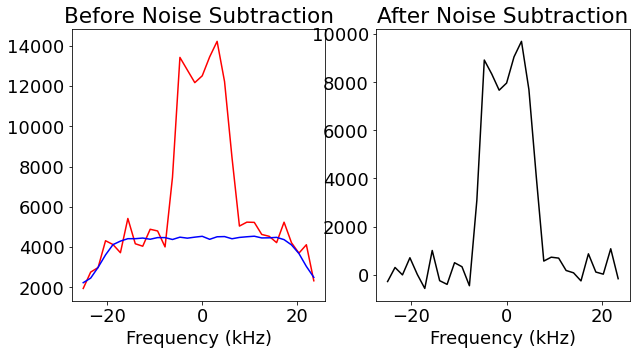

In [11]:
#pick out a cut at a particular altitude
r=320
rind=numpy.argmin(numpy.abs(rng-r))

plt.rcParams['figure.figsize']=10,5
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(1,2)

axarr[0].plot(freq[:-1]*1e-3,fspec[rind,:],'r')
axarr[0].plot(freq[:-1]*1e-3,noisespecnorm,'b')
axarr[0].set_title('Before Noise Subtraction')
axarr[0].set_xlabel('Frequency (kHz)')

axarr[1].plot(freq[:-1]*1e-3,spec[rind,:],'k')
axarr[1].set_title('After Noise Subtraction')
axarr[1].set_xlabel('Frequency (kHz)')
